In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import shutil
import string
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, LSTM, Embedding, BatchNormalization,  Reshape, Conv2D, MaxPool2D, concatenate, Flatten, Activation
import torch
import numpy as np
from transformers import BertTokenizer, BertModel,RobertaTokenizer, RobertaModel
import ast

In [ ]:
# Verificar si la GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AST spliter D. Gries form

In [ ]:
class WhileLoopFinder(ast.NodeVisitor):
    def __init__(self, source_code):
        self.source_code = source_code.splitlines()
        self.functions_with_while = []
        self.current_function = None

    def visit_FunctionDef(self, node):
        original_current_function = self.current_function
        self.current_function = {
            "function_name": node.name,
            "has_while_loop": False,
            "pre_while_code_lines": [],
            "while_loops": []
        }

        function_start_line = node.lineno - 1
        function_end_line = (node.end_lineno if hasattr(node, 'end_lineno') else len(self.source_code))
        function_lines = self.source_code[function_start_line:function_end_line]

        found_while = False
        for stmt in node.body:
            if isinstance(stmt, ast.While):
                self.current_function["has_while_loop"] = True
                found_while = True
                try:
                    while_condition = ast.unparse(stmt.test).strip()
                    print("OK condition")
                except AttributeError:
                    print("Error al obtener la condición del while")
                try:
                    while_body_code = ast.unparse(ast.Module(body=stmt.body, type_ignores=[])).strip()
                    print("Ok body")
                except AttributeError:
                    print("Error al obtener el código del cuerpo del while")

                self.current_function["while_loops"].append({
                    "condition": while_condition,
                    "body_code": while_body_code
                })
            elif not found_while:
                start_line = stmt.lineno - 1
                end_line = (stmt.end_lineno if hasattr(stmt, 'end_lineno') else stmt.lineno)
                self.current_function["pre_while_code_lines"].extend(self.source_code[start_line:end_line])
            self.generic_visit(stmt)

        if self.current_function["has_while_loop"]:
            last_while_end_line = None
            if self.current_function["while_loops"]:
                last_while_node = next((node for node in reversed(node.body) if isinstance(node, ast.While)), None)
                if last_while_node and hasattr(last_while_node, 'end_lineno'):
                    last_while_end_line = last_while_node.end_lineno
            post_while_code_lines = []
            if last_while_end_line:
                function_indent = len(self.source_code[node.lineno - 1]) - len(self.source_code[node.lineno - 1].lstrip())
                for line in self.source_code[last_while_end_line:function_end_line]:
                    if line.startswith(self.source_code[node.lineno - 1][:function_indent] + "    "):
                        post_while_code_lines.append(line[function_indent + 4:])
                    else:
                        post_while_code_lines.append(line[function_indent:])
            self.current_function["post_while_code_lines"] = "\n".join(post_while_code_lines).strip()
            self.current_function["pre_while_code_lines"] = "\n".join(self.current_function["pre_while_code_lines"]).strip()
            self.functions_with_while.append(self.current_function)

        self.current_function = original_current_function



In [ ]:
def DGries_states(solution):
  try:
    # Crear el AST
    tree = ast.parse(solution)
    # Recorrer el AST con nuestro visitante
    finder = WhileLoopFinder(solution)
    finder.visit(tree)
    for func_info in finder.functions_with_while:
      initial_state=func_info["pre_while_code_lines"] if func_info["pre_while_code_lines"] else False
      end_state=""
      transformation_state=""
      for j, wl in enumerate(func_info["while_loops"]):
          end_state=wl["condition"]
          transformation_state=wl["body_code"]

      if not initial_state:
        initial_state=transformation_state
      return initial_state,transformation_state,end_state
  except Exception as error:
    return "Exception:"+str(error),"Exception:"+str(error),"Exception:"+str(error)




# Encoder Description and Code

In [ ]:
class Encoder:
  def __init__(self):
    self.is_loadtokenizers=False



  def tokenize_and_generate_embeddings_descriptions(self,description):
    if not self.is_loadtokenizers:
      raise ValueError("tokenizers dont load")
    # Tokenize input description and move tokens to GPU
    tokens = self.beart_tokenizer.encode_plus(description, return_tensors="pt", truncation=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    # Generate embeddings
    with torch.no_grad():
        outputs = self.beart_model(**tokens)
    # Extract embeddings for all tokens
    desc_embeddings = outputs.last_hidden_state.cpu().numpy()
    return desc_embeddings

  def tokenize_and_generate_embeddings_codes(self,code):
    if not self.is_loadtokenizers:
      raise ValueError("tokenizers dont load")
    # Tokenize input code and move tokens to GPU
    tokens = self.beart_tokenizer.encode_plus(code, return_tensors="pt", truncation=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    # Generate embeddings
    with torch.no_grad():
        outputs = self.codebeart_model(**tokens)
    # Extract embeddings for all tokens
    code_embeddings = outputs.last_hidden_state.cpu().numpy()

    return code_embeddings

  def load_beart_tokenizer(self):
    # Verificar si la GPU está disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cargar el tokenizer y el modelo en la GPU si está disponible
    model_name = "bert-base-uncased"
    self.beart_model = BertModel.from_pretrained(model_name)
    self.beart_tokenizer = BertTokenizer.from_pretrained(model_name)
    self.beart_model.to(device)

  def load_codebert_tokenizer(self):
    # Verificar si la GPU está disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cargar el tokenizer y el modelo en la GPU si está disponible
    self.codebeart_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
    self.codebeart_model = RobertaModel.from_pretrained("microsoft/codebert-base")
    self.codebeart_model.to(device)

  def start_tokenizer(self):
    self.load_beart_tokenizer()
    self.load_codebert_tokenizer()
    self.is_loadtokenizers=True




# All characteristics

In [ ]:
def categoricallabelAll(w):
  if w=="['Correct']":
    return 0
  if w=="['Initial state']":
    return 1
  if w=="['Final state']":
    return 2
  if w=="['State transformation']":
    return 3
  if w=="['Initial state', 'Final state']":
    return 4
  if w=="['Initial state', 'State transformation']":
    return 5
  if w=="['Final state', 'State transformation']":
    return 6
  if w=="['Initial state', 'Final state', 'State transformation']":
    return 7
  return 8

category=np.array([
    'Correct',
    'Initial state',
    'Final state',
    'State transformation',
    'Initial state, Final state',
    'Initial state, State transformation',
    'Final state, State transformation',
    'Initial state, Final state, State transformation'

])

# Load Dataset

In [ ]:
archivo_3 = '/content/drive/MyDrive/Ginna Tesis/DataProgramsandDescriptions-CatRetroalimentacion5000.xlsx'
train_full = pd.read_excel(archivo_3)

In [ ]:
train_full.head()

,No.,Problema,Solución,Estado incial,Estado final,Transformación de estado,Etiqueta 1,Etiqueta 2,Realimentación
0,1,Write a Python function that returns the facto...,def factorial(n):\n result = 1\n i = 1\n...,"result = 1, i = 1",i <= n,"result *= i, i += 1",Correct,['Correct'],NaN
1,2,Write a Python function that returns the sum o...,def sum_1_to_100():\n total = 0\n i = 1\...,"total = 0, i = 1, n = 100",i <= n,"total += i, i += 1",Correct,['Correct'],NaN
2,3,Write a Python function that prints the number...,def print_and_store():\n numbers = []\n ...,"numbers = [], i = 0, n = 10",i <= n,"print(i), numbers.append(i), i += 1",Correct,['Correct'],NaN
3,4,Write a Python function to print the numbers f...,def print_and_store_reverse():\n numbers = ...,"numbers = [], i = 10, n = 1",i >= n,"print(i), numbers.append(i), i -= 1",Correct,['Correct'],NaN
4,5,Write a Python function to check if a number i...,def is_prime(num):\n if num <= 1:\n ...,"i = 2, i = = 0:",i <= num//2,"if num % i == 0:, return False, i += 1",Correct,['Correct'],NaN


In [ ]:
train_full.drop(["No.","Realimentación","Estado incial","Estado final","Transformación de estado"],axis=1,inplace=True)
train_full

,Problema,Solución,Etiqueta 1,Etiqueta 2
0,Write a Python function that returns the facto...,def factorial(n):\n result = 1\n i = 1\n...,Correct,['Correct']
1,Write a Python function that returns the sum o...,def sum_1_to_100():\n total = 0\n i = 1\...,Correct,['Correct']
2,Write a Python function that prints the number...,def print_and_store():\n numbers = []\n ...,Correct,['Correct']
3,Write a Python function to print the numbers f...,def print_and_store_reverse():\n numbers = ...,Correct,['Correct']
4,Write a Python function to check if a number i...,def is_prime(num):\n if num <= 1:\n ...,Correct,['Correct']
...,...,...,...,...
4995,Write a Python function that returns the sum o...,def sum_of_first_five_numbers():\n number =...,Incorrect,"['Initial state', 'Final state']"
4996,Write a Python function that returns the facto...,def factorial(n):\n result = 0\n i = 0\n...,Incorrect,"['Initial state', 'Final state']"
4997,Write a Python function that prints the number...,def print_and_store_numbers():\n numbers = ...,Incorrect,"['Initial state', 'Final state']"
4998,Write a Python function to print the numbers f...,def print_and_store_numbers():\n numbers = ...,Incorrect,"['Initial state', 'Final state']"


In [ ]:
train_full[["Estado incial","Transformación de estado","Estado final"]]=train_full['Solución'].apply(DGries_states).apply(pd.Series)

Streaming output truncated to the last 5000 lines.
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK c

In [ ]:
y=train_full['Etiqueta 2'].apply(categoricallabelAll)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
train_full.dropna(inplace=True)

In [ ]:
np.unique(train_full['Etiqueta 2'])

array(["['Correct']", "['Final state', 'State transformation']",
       "['Final state']",
       "['Initial state', 'Final state', 'State transformation']",
       "['Initial state', 'Final state']",
       "['Initial state', 'State transformation']", "['Initial state']",
       "['State transformation']"], dtype=object)

In [ ]:
encoder=Encoder()
encoder.start_tokenizer()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
%%time
problem=train_full['Problema'].apply(encoder.tokenize_and_generate_embeddings_descriptions).to_numpy()
startstate = train_full['Estado incial'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()
finalstate = train_full['Estado final'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()
transstate = train_full['Transformación de estado'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

CPU times: user 3min 26s, sys: 3.9 s, total: 3min 30s
Wall time: 3min 50s


In [ ]:
problem.shape,startstate.shape,finalstate.shape,transstate.shape

((4919,), (4919,), (4919,), (4919,))

In [ ]:
print(startstate.shape)
print(startstate[1262].shape)


(4919,)
(1, 11, 768)


In [ ]:
Xp=np.array([sentence[0].mean(axis=0) for sentence in problem])
Xs=np.array([sentence[0].mean(axis=0) for sentence in startstate])
Xf=np.array([sentence[0].mean(axis=0) for sentence in finalstate])
Xt=np.array([sentence[0].mean(axis=0) for sentence in transstate])
Xp.shape,Xs.shape,Xf.shape,Xt.shape

((4919, 768), (4919, 768), (4919, 768), (4919, 768))

In [ ]:
y=train_full['Etiqueta 2'].apply(categoricallabelAll)
y=y.to_numpy()
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
def mytraintestsplit(X,y,test_size=0.2 ,random_state=2023):
  n=y.shape[0]
  index=np.array(range(0,n))
  np.random.seed(2023)
  np.random.shuffle(index)
  ntest=int(n*test_size)
  ntrain=n-ntest
  Xshufle=[]
  for x in X:
    Xshufle.append(x[index])
  y=y[index]

  Xtrain=[]
  for x in Xshufle:
    Xtrain.append(x[0:ntrain])

  Xtest=[]
  for x in Xshufle:
    Xtest.append(x[ntrain:n])

  return np.array(Xtrain),np.array(Xtest),y[0:ntrain],y[ntrain:n]



In [ ]:
Xtrain,Xtest,ytrain,ytest=mytraintestsplit([Xp,Xs,Xt,Xf],y)

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape,ytrain.shape

((4, 3936, 768), (4, 983, 768), (3936,), (3936,))

In [ ]:
4913*0.8

3930.4

# Keras model

In [ ]:
problem_input=Input((768,))

mlp_p=Dense(10000)(problem_input)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.5)(mlp_p)

mlp_p=Dense(1000)(mlp_p)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.2)(mlp_p)

mlp_p=Dense(10000)(mlp_p)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.2)(mlp_p)

## Start vector

start_input=Input((768,))

mlp_s=Dense(10000)(start_input)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.5)(mlp_s)

mlp_s=Dense(1000)(mlp_s)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.2)(mlp_s)

mlp_s=Dense(10000)(mlp_s)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.2)(mlp_s)


##Transformation vector

trass_input=Input((768,))

mlp_t=Dense(10000)(trass_input)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.5)(mlp_t)

mlp_t=Dense(1000)(mlp_t)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.2)(mlp_t)

mlp_t=Dense(10000)(mlp_t)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.2)(mlp_t)


## Final vector

final_input=Input((768,))

mlp_f=Dense(10000)(final_input)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.5)(mlp_f)

mlp_f=Dense(1000)(mlp_f)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.2)(mlp_f)

mlp_f=Dense(10000)(mlp_f)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.2)(mlp_f)

## Concatenate All models
combined = concatenate([mlp_p, mlp_s, mlp_t,mlp_f])

## output layer

output=Dense(8)(combined)
output=BatchNormalization()(output)
output=Activation('softmax')(output)

## Model

model = Model(inputs=[problem_input, start_input, trass_input,final_input], outputs=output)


model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10000)     │  7,690,000 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10000)     │     40,000 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10000)     │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10000)     │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10000)     │          0 │ activation_6[0][

 Total params: 111,460,040 (425.19 MB)

 Trainable params: 111,292,024 (424.55 MB)

 Non-trainable params: 168,016 (656.31 KB)

In [ ]:
adam = Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=25)
mc = ModelCheckpoint('/content/drive/MyDrive/Ginna Tesis/best_finall.h5', monitor='val_accuracy', mode='max', save_best_only=True)
history=model.fit([Xtrain[0], Xtrain[1], Xtrain[2],Xtrain[3]],ytrain,batch_size=100,epochs=5000,
          validation_split=0.2,callbacks=[es, mc])

Epoch 1/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.1612 - loss: 2.3360

32/32 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.1619 - loss: 2.3335 - val_accuracy: 0.0305 - val_loss: 2.0921
Epoch 2/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2837 - loss: 1.9072

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.2843 - loss: 1.9068 - val_accuracy: 0.0343 - val_loss: 2.1393
Epoch 3/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 126ms/step - accuracy: 0.3688 - loss: 1.7616 - val_accuracy: 0.0292 - val_loss: 2.1821
Epoch 4/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4220 - loss: 1.6783 - val_accuracy: 0.0254 - val_loss: 2.2141
Epoch 5/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.4705 - loss: 1.5835 - val_accuracy: 0.0254 - val_loss: 2.2426
Epoch 6/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5086 - loss: 1.5220 - val_accuracy: 0.0254 - val_loss: 2.2554
Epoch 7/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.5085 - loss: 1.5110 - val_accuracy: 0.0254 - val_loss: 2.2604
Epoch 8/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5333 - loss: 1.4485 - val_accuracy: 0.0266 - val_loss: 2.2515
Epoch 9/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5700 - loss: 1.4114 - val_accuracy: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.6000 - loss: 1.3692 - val_accuracy: 0.0558 - val_loss: 2.1795
Epoch 11/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5933 - loss: 1.3574

32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5936 - loss: 1.3570 - val_accuracy: 0.0939 - val_loss: 2.1102
Epoch 12/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6252 - loss: 1.2999

32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 973ms/step - accuracy: 0.6251 - loss: 1.3003 - val_accuracy: 0.1345 - val_loss: 2.0429
Epoch 13/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6523 - loss: 1.2639

32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6518 - loss: 1.2643 - val_accuracy: 0.2107 - val_loss: 1.9495
Epoch 14/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6548 - loss: 1.2645

32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6547 - loss: 1.2643 - val_accuracy: 0.3211 - val_loss: 1.8418
Epoch 15/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6578 - loss: 1.2420

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6578 - loss: 1.2419 - val_accuracy: 0.4302 - val_loss: 1.7271
Epoch 16/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6990 - loss: 1.2006

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 797ms/step - accuracy: 0.6986 - loss: 1.2009 - val_accuracy: 0.5228 - val_loss: 1.6123
Epoch 17/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6818 - loss: 1.1991

32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6820 - loss: 1.1988 - val_accuracy: 0.5876 - val_loss: 1.5030
Epoch 18/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7005 - loss: 1.1870

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7005 - loss: 1.1870 - val_accuracy: 0.6320 - val_loss: 1.4296
Epoch 19/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6979 - loss: 1.1785

32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.6981 - loss: 1.1781 - val_accuracy: 0.6472 - val_loss: 1.3545
Epoch 20/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7173 - loss: 1.1404

32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7170 - loss: 1.1408 - val_accuracy: 0.6599 - val_loss: 1.2771
Epoch 21/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7101 - loss: 1.1371

32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 682ms/step - accuracy: 0.7100 - loss: 1.1373 - val_accuracy: 0.6865 - val_loss: 1.2280
Epoch 22/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7195 - loss: 1.1380

32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 891ms/step - accuracy: 0.7196 - loss: 1.1380 - val_accuracy: 0.7094 - val_loss: 1.1800
Epoch 23/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7389 - loss: 1.1015

32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7388 - loss: 1.1017 - val_accuracy: 0.7157 - val_loss: 1.1229
Epoch 24/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7389 - loss: 1.1027

32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 737ms/step - accuracy: 0.7389 - loss: 1.1026 - val_accuracy: 0.7183 - val_loss: 1.0910
Epoch 25/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7619 - loss: 1.0649

32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 933ms/step - accuracy: 0.7617 - loss: 1.0654 - val_accuracy: 0.7195 - val_loss: 1.0626
Epoch 26/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7584 - loss: 1.0755

32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7582 - loss: 1.0757 - val_accuracy: 0.7348 - val_loss: 1.0521
Epoch 27/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.7484 - loss: 1.0860 - val_accuracy: 0.7335 - val_loss: 1.0259
Epoch 28/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7673 - loss: 1.0667

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 810ms/step - accuracy: 0.7674 - loss: 1.0665 - val_accuracy: 0.7386 - val_loss: 1.0061
Epoch 29/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7729 - loss: 1.0506

32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 839ms/step - accuracy: 0.7731 - loss: 1.0503 - val_accuracy: 0.7475 - val_loss: 1.0037
Epoch 30/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7803 - loss: 1.0319

32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7801 - loss: 1.0324 - val_accuracy: 0.7551 - val_loss: 0.9926
Epoch 31/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7910 - loss: 1.0260

32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 927ms/step - accuracy: 0.7907 - loss: 1.0261 - val_accuracy: 0.7602 - val_loss: 0.9670
Epoch 32/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7873 - loss: 1.0268

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7872 - loss: 1.0267 - val_accuracy: 0.7640 - val_loss: 0.9630
Epoch 33/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7986 - loss: 1.0061

32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 780ms/step - accuracy: 0.7985 - loss: 1.0062 - val_accuracy: 0.7741 - val_loss: 0.9499
Epoch 34/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7928 - loss: 1.0063

32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.7929 - loss: 1.0063 - val_accuracy: 0.7766 - val_loss: 0.9406
Epoch 35/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7880 - loss: 1.0071

32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 963ms/step - accuracy: 0.7879 - loss: 1.0071 - val_accuracy: 0.7868 - val_loss: 0.9405
Epoch 36/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8131 - loss: 0.9848

32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8131 - loss: 0.9849 - val_accuracy: 0.7919 - val_loss: 0.9206
Epoch 37/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8007 - loss: 0.9953

32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8009 - loss: 0.9950 - val_accuracy: 0.7982 - val_loss: 0.9115
Epoch 38/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 115ms/step - accuracy: 0.8110 - loss: 0.9716 - val_accuracy: 0.7970 - val_loss: 0.9215
Epoch 39/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8135 - loss: 0.9672

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8136 - loss: 0.9673 - val_accuracy: 0.7995 - val_loss: 0.9022
Epoch 40/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8070 - loss: 0.9834

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 578ms/step - accuracy: 0.8074 - loss: 0.9828 - val_accuracy: 0.8033 - val_loss: 0.8905
Epoch 41/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8214 - loss: 0.9615 - val_accuracy: 0.8033 - val_loss: 0.8905
Epoch 42/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.8309 - loss: 0.9620 - val_accuracy: 0.8008 - val_loss: 0.8919
Epoch 43/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8240 - loss: 0.9523 - val_accuracy: 0.7995 - val_loss: 0.8975
Epoch 44/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8427 - loss: 0.9383

32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8425 - loss: 0.9385 - val_accuracy: 0.8173 - val_loss: 0.8656
Epoch 45/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.8380 - loss: 0.9436 - val_accuracy: 0.8058 - val_loss: 0.8881
Epoch 46/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.8409 - loss: 0.9292 - val_accuracy: 0.8109 - val_loss: 0.8686
Epoch 47/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.8530 - loss: 0.9119 - val_accuracy: 0.8135 - val_loss: 0.8664
Epoch 48/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8464 - loss: 0.9234

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 749ms/step - accuracy: 0.8462 - loss: 0.9236 - val_accuracy: 0.8198 - val_loss: 0.8703
Epoch 49/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.8661 - loss: 0.9085 - val_accuracy: 0.8160 - val_loss: 0.8528
Epoch 50/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8514 - loss: 0.9028 - val_accuracy: 0.8160 - val_loss: 0.8494
Epoch 51/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8459 - loss: 0.9074 - val_accuracy: 0.8198 - val_loss: 0.8496
Epoch 52/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8551 - loss: 0.9046

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 574ms/step - accuracy: 0.8551 - loss: 0.9045 - val_accuracy: 0.8211 - val_loss: 0.8369
Epoch 53/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8482 - loss: 0.9074

32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 964ms/step - accuracy: 0.8483 - loss: 0.9072 - val_accuracy: 0.8249 - val_loss: 0.8413
Epoch 54/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.8688 - loss: 0.8863 - val_accuracy: 0.8236 - val_loss: 0.8308
Epoch 55/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8683 - loss: 0.8861

32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8682 - loss: 0.8862 - val_accuracy: 0.8261 - val_loss: 0.8385
Epoch 56/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.8684 - loss: 0.8950 - val_accuracy: 0.8223 - val_loss: 0.8228
Epoch 57/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8582 - loss: 0.8937 - val_accuracy: 0.8261 - val_loss: 0.8287
Epoch 58/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8733 - loss: 0.8736

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8732 - loss: 0.8738 - val_accuracy: 0.8363 - val_loss: 0.8141
Epoch 59/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8672 - loss: 0.8824 - val_accuracy: 0.8338 - val_loss: 0.8197
Epoch 60/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8747 - loss: 0.8612 - val_accuracy: 0.8249 - val_loss: 0.8163
Epoch 61/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.8660 - loss: 0.8832 - val_accuracy: 0.8261 - val_loss: 0.8202
Epoch 62/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8846 - loss: 0.8566

32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8844 - loss: 0.8568 - val_accuracy: 0.8376 - val_loss: 0.7964
Epoch 63/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.8769 - loss: 0.8522 - val_accuracy: 0.8350 - val_loss: 0.8058
Epoch 64/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8967 - loss: 0.8379 - val_accuracy: 0.8299 - val_loss: 0.7844
Epoch 65/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8698 - loss: 0.8695 - val_accuracy: 0.8312 - val_loss: 0.7862
Epoch 66/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.8795 - loss: 0.8519 - val_accuracy: 0.8363 - val_loss: 0.7892
Epoch 67/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8811 - loss: 0.8495 - val_accuracy: 0.8325 - val_loss: 0.7769
Epoch 68/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8961 - loss: 0.8441 - val_accuracy: 0.8325 - val_loss: 0.7836
Epoch 69/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8883 - loss: 0.8390 - val_accu

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 661ms/step - accuracy: 0.9003 - loss: 0.8190 - val_accuracy: 0.8414 - val_loss: 0.7779
Epoch 73/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8888 - loss: 0.8435

32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8889 - loss: 0.8433 - val_accuracy: 0.8426 - val_loss: 0.7690
Epoch 74/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.8833 - loss: 0.8374 - val_accuracy: 0.8426 - val_loss: 0.7695
Epoch 75/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8894 - loss: 0.8294 - val_accuracy: 0.8363 - val_loss: 0.7576
Epoch 76/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9002 - loss: 0.8112 - val_accuracy: 0.8338 - val_loss: 0.7591
Epoch 77/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8959 - loss: 0.8134 - val_accuracy: 0.8426 - val_loss: 0.7587
Epoch 78/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9028 - loss: 0.8192 - val_accuracy: 0.8363 - val_loss: 0.7466
Epoch 79/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8958 - loss: 0.8193

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 791ms/step - accuracy: 0.8957 - loss: 0.8192 - val_accuracy: 0.8477 - val_loss: 0.7609
Epoch 80/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8933 - loss: 0.8157 - val_accuracy: 0.8439 - val_loss: 0.7475
Epoch 81/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9074 - loss: 0.8100 - val_accuracy: 0.8414 - val_loss: 0.7650
Epoch 82/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8991 - loss: 0.8092 - val_accuracy: 0.8426 - val_loss: 0.7512
Epoch 83/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9231 - loss: 0.7774 - val_accuracy: 0.8426 - val_loss: 0.7384
Epoch 84/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9047 - loss: 0.7974 - val_accuracy: 0.8414 - val_loss: 0.7437
Epoch 85/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9153 - loss: 0.7998

32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9151 - loss: 0.7999 - val_accuracy: 0.8490 - val_loss: 0.7314
Epoch 86/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.9197 - loss: 0.7864 - val_accuracy: 0.8452 - val_loss: 0.7331
Epoch 87/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9082 - loss: 0.7847 - val_accuracy: 0.8464 - val_loss: 0.7434
Epoch 88/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9121 - loss: 0.8005 - val_accuracy: 0.8350 - val_loss: 0.7329
Epoch 89/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9172 - loss: 0.7877 - val_accuracy: 0.8401 - val_loss: 0.7437
Epoch 90/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9223 - loss: 0.7732 - val_accuracy: 0.8452 - val_loss: 0.7260
Epoch 91/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9196 - loss: 0.7827

32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 808ms/step - accuracy: 0.9194 - loss: 0.7828 - val_accuracy: 0.8528 - val_loss: 0.7366
Epoch 92/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9192 - loss: 0.7797 - val_accuracy: 0.8426 - val_loss: 0.7349
Epoch 93/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9067 - loss: 0.7882 - val_accuracy: 0.8528 - val_loss: 0.7342
Epoch 94/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9238 - loss: 0.7737 - val_accuracy: 0.8503 - val_loss: 0.7111
Epoch 95/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9220 - loss: 0.7714 - val_accuracy: 0.8515 - val_loss: 0.7140
Epoch 96/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9267 - loss: 0.7680 - val_accuracy: 0.8528 - val_loss: 0.7037
Epoch 97/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9256 - loss: 0.7712 - val_accuracy: 0.8477 - val_loss: 0.7252
Epoch 98/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9111 - loss: 0.7715 - val_a

32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9234 - loss: 0.7638 - val_accuracy: 0.8541 - val_loss: 0.6993
Epoch 102/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - accuracy: 0.9284 - loss: 0.7526 - val_accuracy: 0.8528 - val_loss: 0.7026
Epoch 103/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9249 - loss: 0.7671

32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9248 - loss: 0.7671 - val_accuracy: 0.8553 - val_loss: 0.7140
Epoch 104/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9275 - loss: 0.7659 - val_accuracy: 0.8528 - val_loss: 0.7058
Epoch 105/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9320 - loss: 0.7467 - val_accuracy: 0.8553 - val_loss: 0.7027
Epoch 106/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9268 - loss: 0.7625 - val_accuracy: 0.8515 - val_loss: 0.6939
Epoch 107/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9340 - loss: 0.7400

32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.9338 - loss: 0.7404 - val_accuracy: 0.8604 - val_loss: 0.6963
Epoch 108/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9137 - loss: 0.7505 - val_accuracy: 0.8553 - val_loss: 0.6938
Epoch 109/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9395 - loss: 0.7327 - val_accuracy: 0.8515 - val_loss: 0.6956
Epoch 110/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9304 - loss: 0.7411 - val_accuracy: 0.8541 - val_loss: 0.6866
Epoch 111/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9281 - loss: 0.7508 - val_accuracy: 0.8604 - val_loss: 0.6870
Epoch 112/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9427 - loss: 0.7197 - val_accuracy: 0.8553 - val_loss: 0.6914
Epoch 113/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9400 - loss: 0.7303 - val_accuracy: 0.8591 - val_loss: 0.6869
Epoch 114/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9289 - loss: 0.7504

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - accuracy: 0.9305 - loss: 0.7404 - val_accuracy: 0.8642 - val_loss: 0.6844
Epoch 120/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9485 - loss: 0.7206 - val_accuracy: 0.8579 - val_loss: 0.6800
Epoch 121/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9428 - loss: 0.7267 - val_accuracy: 0.8553 - val_loss: 0.6637
Epoch 122/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9296 - loss: 0.7357 - val_accuracy: 0.8515 - val_loss: 0.6749
Epoch 123/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9403 - loss: 0.7160 - val_accuracy: 0.8528 - val_loss: 0.6763
Epoch 124/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9368 - loss: 0.7239 - val_accuracy: 0.8553 - val_loss: 0.6718
Epoch 125/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9477 - loss: 0.7115 - val_accuracy: 0.8591 - val_loss: 0.6708
Epoch 126/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9325 - loss: 0.7340 

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 991ms/step - accuracy: 0.9403 - loss: 0.7083 - val_accuracy: 0.8655 - val_loss: 0.6566
Epoch 134/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9467 - loss: 0.6950

32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9466 - loss: 0.6952 - val_accuracy: 0.8668 - val_loss: 0.6538
Epoch 135/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9474 - loss: 0.7051 - val_accuracy: 0.8604 - val_loss: 0.6630
Epoch 136/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9487 - loss: 0.6921 - val_accuracy: 0.8541 - val_loss: 0.6522
Epoch 137/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9459 - loss: 0.6992 - val_accuracy: 0.8629 - val_loss: 0.6501
Epoch 138/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9409 - loss: 0.6972 - val_accuracy: 0.8591 - val_loss: 0.6546
Epoch 139/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9381 - loss: 0.7077 - val_accuracy: 0.8604 - val_loss: 0.6655
Epoch 140/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9506 - loss: 0.6872 - val_accuracy: 0.8668 - val_loss: 0.6573
Epoch 141/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9480 - loss: 0.6967 - v

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 960ms/step - accuracy: 0.9424 - loss: 0.7109 - val_accuracy: 0.8680 - val_loss: 0.6614
Epoch 145/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9523 - loss: 0.6910 - val_accuracy: 0.8655 - val_loss: 0.6549
Epoch 146/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9497 - loss: 0.6871 - val_accuracy: 0.8642 - val_loss: 0.6554
Epoch 147/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9478 - loss: 0.6874 - val_accuracy: 0.8680 - val_loss: 0.6575
Epoch 148/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9657 - loss: 0.6620 - val_accuracy: 0.8617 - val_loss: 0.6467
Epoch 149/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9457 - loss: 0.6970 - val_accuracy: 0.8604 - val_loss: 0.6446
Epoch 150/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9475 - loss: 0.6960 - val_accuracy: 0.8655 - val_loss: 0.6445
Epoch 151/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9540 - loss: 0.6761

32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9538 - loss: 0.6764 - val_accuracy: 0.8693 - val_loss: 0.6441
Epoch 152/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9556 - loss: 0.6889

32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 820ms/step - accuracy: 0.9555 - loss: 0.6888 - val_accuracy: 0.8731 - val_loss: 0.6395
Epoch 153/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9537 - loss: 0.6752 - val_accuracy: 0.8668 - val_loss: 0.6402
Epoch 154/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9541 - loss: 0.6708 - val_accuracy: 0.8680 - val_loss: 0.6525
Epoch 155/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9528 - loss: 0.6744 - val_accuracy: 0.8668 - val_loss: 0.6473
Epoch 156/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9474 - loss: 0.6784 - val_accuracy: 0.8706 - val_loss: 0.6448
Epoch 157/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9587 - loss: 0.6810 - val_accuracy: 0.8680 - val_loss: 0.6465
Epoch 158/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9577 - loss: 0.6631 - val_accuracy: 0.8668 - val_loss: 0.6453
Epoch 159/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9428 - loss: 0.6850 

32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9508 - loss: 0.6573 - val_accuracy: 0.8744 - val_loss: 0.6382
Epoch 164/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.9504 - loss: 0.6732 - val_accuracy: 0.8668 - val_loss: 0.6375
Epoch 165/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9489 - loss: 0.6823 - val_accuracy: 0.8680 - val_loss: 0.6435
Epoch 166/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9517 - loss: 0.6672 - val_accuracy: 0.8668 - val_loss: 0.6374
Epoch 167/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9601 - loss: 0.6595

32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9601 - loss: 0.6595 - val_accuracy: 0.8756 - val_loss: 0.6316
Epoch 168/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9553 - loss: 0.6688 - val_accuracy: 0.8680 - val_loss: 0.6385
Epoch 169/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9549 - loss: 0.6718 - val_accuracy: 0.8629 - val_loss: 0.6411
Epoch 170/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9572 - loss: 0.6615 - val_accuracy: 0.8655 - val_loss: 0.6387
Epoch 171/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9593 - loss: 0.6575 - val_accuracy: 0.8655 - val_loss: 0.6293
Epoch 172/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9556 - loss: 0.6599 - val_accuracy: 0.8629 - val_loss: 0.6304
Epoch 173/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9531 - loss: 0.6670 - val_accuracy: 0.8591 - val_loss: 0.6310
Epoch 174/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9541 - loss: 0.6646 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 952ms/step - accuracy: 0.9540 - loss: 0.6687 - val_accuracy: 0.8769 - val_loss: 0.6281
Epoch 184/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.9588 - loss: 0.6479 - val_accuracy: 0.8769 - val_loss: 0.6181
Epoch 185/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9531 - loss: 0.6438 - val_accuracy: 0.8718 - val_loss: 0.6289
Epoch 186/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9634 - loss: 0.6429 - val_accuracy: 0.8756 - val_loss: 0.6260
Epoch 187/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9560 - loss: 0.6375 - val_accuracy: 0.8693 - val_loss: 0.6267
Epoch 188/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9612 - loss: 0.6443 - val_accuracy: 0.8706 - val_loss: 0.6345
Epoch 189/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9633 - loss: 0.6428 - val_accuracy: 0.8731 - val_loss: 0.6284
Epoch 190/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9631 - loss: 0.6451

32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9629 - loss: 0.6383 - val_accuracy: 0.8845 - val_loss: 0.6180
Epoch 203/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9659 - loss: 0.6261 - val_accuracy: 0.8769 - val_loss: 0.6201
Epoch 204/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9599 - loss: 0.6323 - val_accuracy: 0.8744 - val_loss: 0.6189
Epoch 205/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9658 - loss: 0.6317 - val_accuracy: 0.8718 - val_loss: 0.6161
Epoch 206/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9587 - loss: 0.6260 - val_accuracy: 0.8744 - val_loss: 0.6207
Epoch 207/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9594 - loss: 0.6306 - val_accuracy: 0.8807 - val_loss: 0.6180
Epoch 208/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9635 - loss: 0.6162 - val_accuracy: 0.8680 - val_loss: 0.6235
Epoch 209/5000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9654 - loss: 0.6300 - 

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [ ]:
N=len(train_loss)

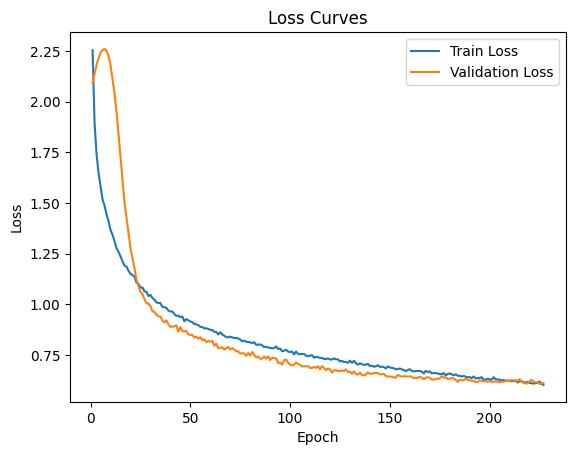

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, N+1), train_loss, label='Train Loss')
plt.plot(range(1, N+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


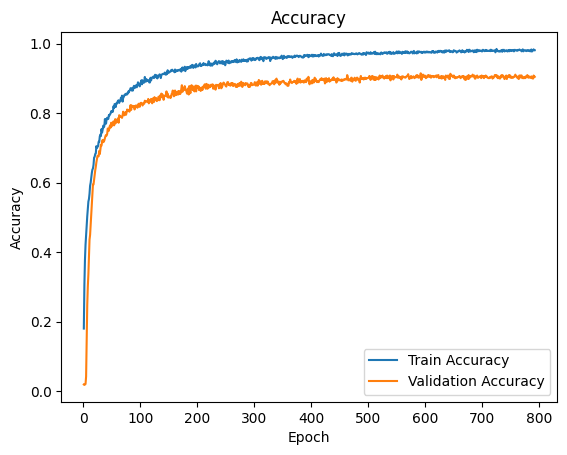

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, N+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, N+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
bestmodel = load_model('/content/drive/MyDrive/Ginna Tesis/best_finall.h5')

In [ ]:
yp=bestmodel.predict([Xtest[0],Xtest[1],Xtest[2],Xtest[3]])

31/31 [==============================] - 1s 5ms/step


In [ ]:
print(classification_report(ytest,yp.argmax(axis=1),target_names=category))

                                                  precision    recall  f1-score   support

                                         Correct       0.88      0.91      0.89       297
                                   Initial state       0.93      0.95      0.94       190
                                     Final state       0.95      0.99      0.97       196
                            State transformation       0.94      0.82      0.87       196
                      Initial state, Final state       0.91      0.97      0.94        32
             Initial state, State transformation       0.74      0.74      0.74        27
               Final state, State transformation       0.84      0.76      0.80        21
Initial state, Final state, State transformation       0.88      1.00      0.94        23

                                        accuracy                           0.91       982
                                       macro avg       0.88      0.89      0.89       982
        